# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

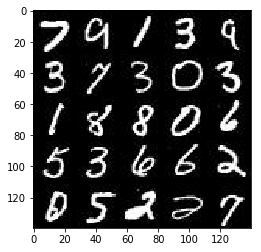

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

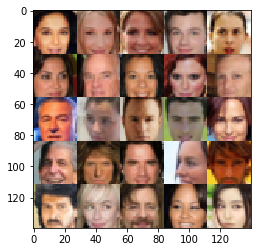

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        lay1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        lay1 = tf.maximum(alpha * lay1, lay1)
        
        lay2 = tf.layers.conv2d(lay1, 128, 5, 2, 'same')
        lay2 = tf.layers.batch_normalization(lay2, training=True)
        lay2 = tf.maximum(alpha * lay2, lay2)
        
        lay3 = tf.layers.conv2d(lay2, 256, 5, 2, 'same')
        lay3 = tf.layers.batch_normalization(lay3, training=True)
        lay3 = tf.maximum(alpha * lay3, lay3)

        flat = tf.reshape(lay3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        lay1 = tf.layers.dense(z, 2*2*512)
        lay1 = tf.reshape(lay1, (-1, 2, 2, 512))
        lay1 = tf.layers.batch_normalization(lay1, training=is_train)
        lay1 = tf.maximum(alpha * lay1, lay1)
    
        lay2 = tf.layers.conv2d_transpose(lay1, 256, 5, 2, 'valid')
        lay2 = tf.layers.batch_normalization(lay2, training=is_train)
        lay2 = tf.maximum(alpha * lay2, lay2)
    
        lay3 = tf.layers.conv2d_transpose(lay2, 128, 5, 2, 'same')
        lay3 = tf.layers.batch_normalization(lay3, training=is_train)
        lay3 = tf.maximum(alpha * lay3, lay3)
    
        logits = tf.layers.conv2d_transpose(lay3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    n_images = 25
    print_every = 15
    show_every = 100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 1.0876
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 7.9808
Epoch 1/2... Discriminator Loss: 2.1796... Generator Loss: 9.6727
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.1530
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 0.9490


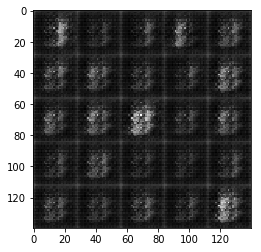

Epoch 1/2... Discriminator Loss: 0.3872... Generator Loss: 1.8617
Epoch 1/2... Discriminator Loss: 0.2542... Generator Loss: 2.2769
Epoch 1/2... Discriminator Loss: 0.2179... Generator Loss: 2.4551
Epoch 1/2... Discriminator Loss: 0.1690... Generator Loss: 2.8250
Epoch 1/2... Discriminator Loss: 0.3001... Generator Loss: 2.3886
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 2.0428
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.8373


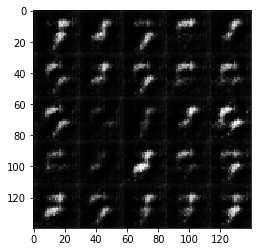

Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 5.0699
Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 2.1375
Epoch 1/2... Discriminator Loss: 0.3272... Generator Loss: 2.1303
Epoch 1/2... Discriminator Loss: 0.4590... Generator Loss: 2.0584
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 0.6455... Generator Loss: 1.1859
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 3.0005


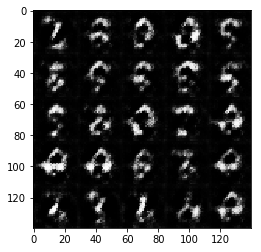

Epoch 1/2... Discriminator Loss: 0.4748... Generator Loss: 1.9681
Epoch 1/2... Discriminator Loss: 0.6536... Generator Loss: 1.1460
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 4.9097
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 1.8655
Epoch 1/2... Discriminator Loss: 0.6981... Generator Loss: 1.4449
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.8441


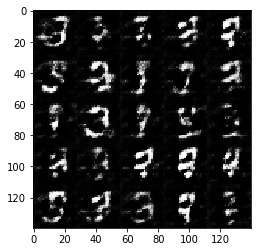

Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 1.1629
Epoch 1/2... Discriminator Loss: 0.6287... Generator Loss: 1.8531
Epoch 1/2... Discriminator Loss: 0.7512... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 0.5529... Generator Loss: 1.9492
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.2682
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 1.7325
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.1757


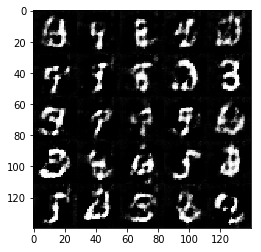

Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.2248
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.7183
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 2.6118
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.1241
Epoch 1/2... Discriminator Loss: 0.7490... Generator Loss: 1.1995
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 0.7328


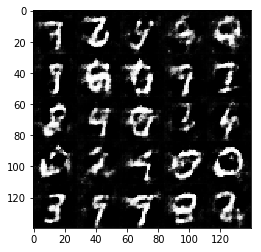

Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.0280
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.1198
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 2.1322
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 2.3326
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 2.0014


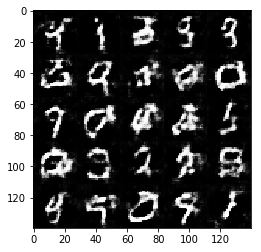

Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 2.1273
Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 1.6864
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 1.5601
Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 2.5852
Epoch 1/2... Discriminator Loss: 0.8487... Generator Loss: 0.9795
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 1.6883


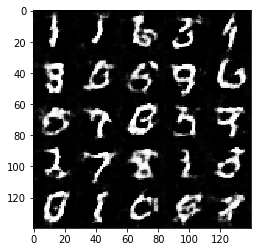

Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 2.0527
Epoch 1/2... Discriminator Loss: 0.6257... Generator Loss: 1.5776
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 0.8493
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.4492
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 2.1050


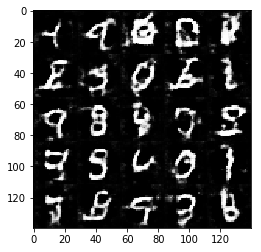

Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.8736
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.4295
Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 1.0937


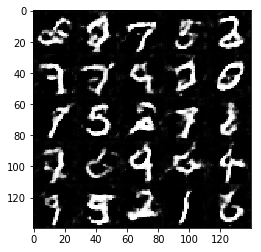

Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.2739
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.0864
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.4035
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 1.0794


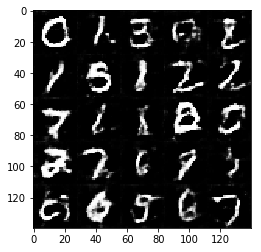

Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 2.2580
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.0580
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 1.3879
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 2.0991... Generator Loss: 0.1850


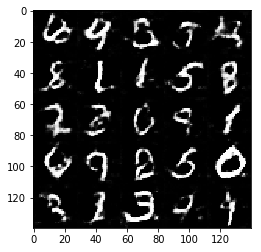

Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 0.9312
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.3852
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 1.0020
Epoch 2/2... Discriminator Loss: 0.6606... Generator Loss: 1.5671
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 0.7583


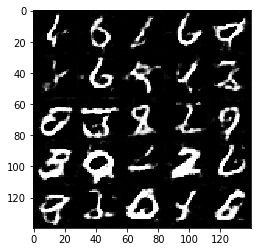

Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.3635
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.3825
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 0.3508
Epoch 2/2... Discriminator Loss: 0.6617... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 0.6049... Generator Loss: 1.4595
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 1.1702


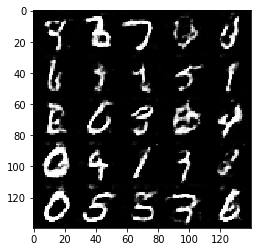

Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.5424
Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 1.4666
Epoch 2/2... Discriminator Loss: 2.4507... Generator Loss: 3.3693


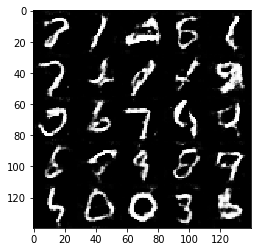

Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 2.7251
Epoch 2/2... Discriminator Loss: 0.6347... Generator Loss: 1.3273
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 0.9229


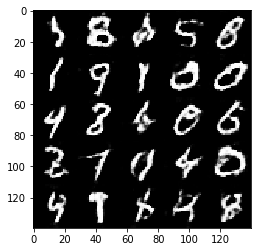

Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 1.8590
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.6142
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 2.1158


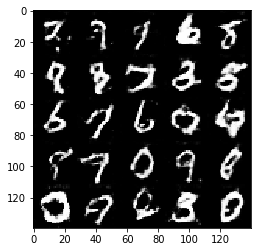

Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 1.5311
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 0.6129... Generator Loss: 1.3080
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 0.7110


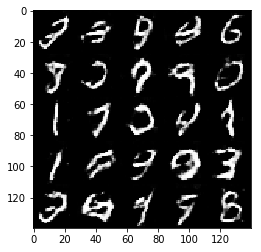

Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 3.0133
Epoch 2/2... Discriminator Loss: 1.1730... Generator Loss: 0.5233
Epoch 2/2... Discriminator Loss: 0.5352... Generator Loss: 1.5223
Epoch 2/2... Discriminator Loss: 0.6022... Generator Loss: 1.1736


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 2.7856... Generator Loss: 0.0754
Epoch 1/1... Discriminator Loss: 0.2977... Generator Loss: 4.0090
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 1.5964
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.5547


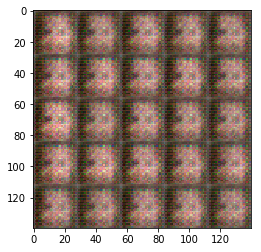

Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 2.4555
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.3822
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 2.4963
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 4.1787
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 3.2000
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.9163


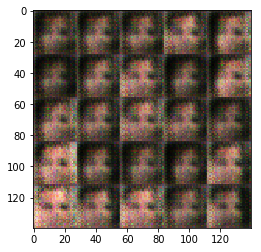

Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 2.3587
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0088


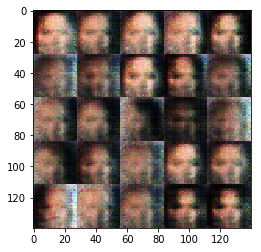

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 2.9438
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.6653
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.8022
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.6649


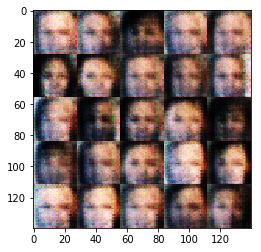

Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.2433


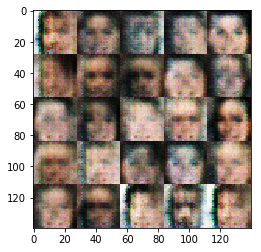

Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.7051
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.6223


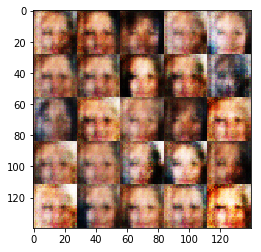

Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.1092


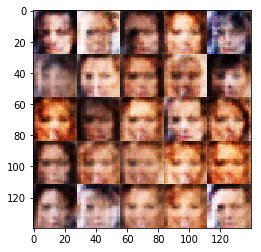

Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.9736
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.4462
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6654


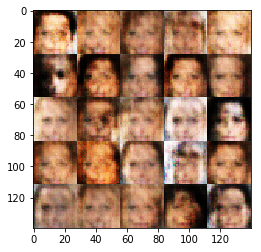

Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1390


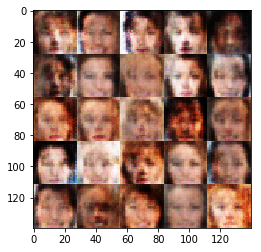

Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.4027


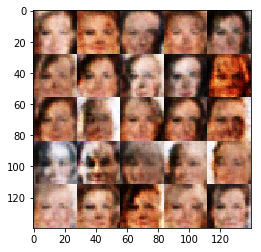

Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.5763


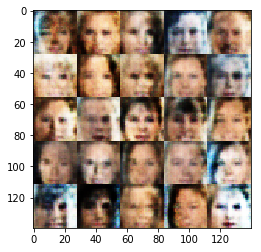

Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 1.8436
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7894


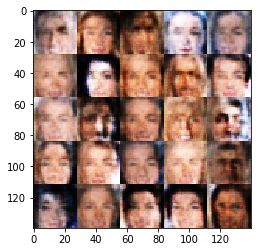

Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.3252


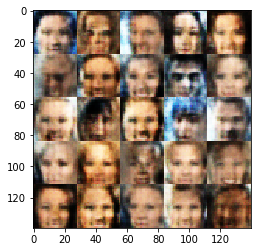

Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.5873
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.2549


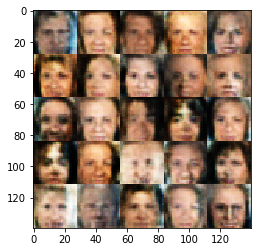

Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.8076


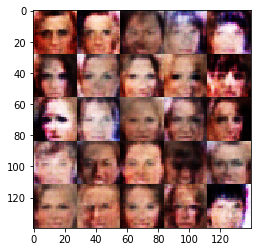

Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 2.2502
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.0229


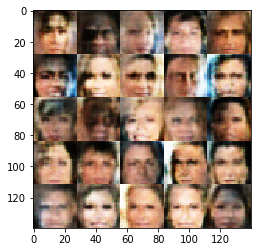

Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 1.6842
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.2990


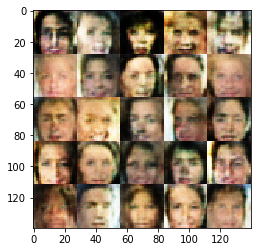

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.